# Plottings

1. calibration curse of FB13-ComplEx and WN-TransE
2. training losses

In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece

from ampligraph.evaluation import generate_corruptions_for_fit, generate_corruptions_for_eval

In [2]:
from ampligraph.utils import restore_model
import os
from sklearn.calibration import CalibrationDisplay
from scipy.special import expit
from sklearn.metrics import accuracy_score

In [5]:
path = r'F:\TREAT\kgcal\saved_models\fb_comp'
fb_comps = { p: restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))}

path = r'F:\TREAT\kgcal\saved_models\wn_transe'
wn_trans = { p: restore_model(os.path.join(path, p)) for p in os.listdir(path)  if os.path.isfile(os.path.join(path, p))}


In [6]:
ds = get_datasets()

## calibration curves of differnet losse

In [7]:

def plot_cal(model, data, ax=None, name=''):
    scores = model.predict(data.X_test)
    probs = expit(scores)
    print(probs)
    CalibrationDisplay.from_predictions(data.y_test, probs, ax=ax, name=name, n_bins=10)


[0.9999819  0.02084817 0.8461259  ... 0.99826765 0.03930025 0.25571385]
[5.34305215e-01 1.26168815e-11 7.01739872e-03 ... 1.04030340e-04
 2.99927929e-14 1.14422125e-10]
[0.8795546  0.28497428 0.5074157  ... 0.8274949  0.45049557 0.5181158 ]
[1.2824890e-01 4.2509560e-06 1.0577977e-02 ... 3.3432611e-06 1.3676887e-04
 9.9993686e-06]


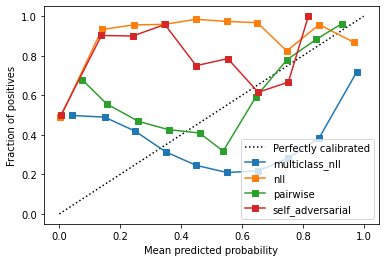

In [9]:
fig, ax = plt.subplots()
for name, model in fb_comps.items():
    plot_cal(model, ds.fb13, ax, name[5:-4])

[1.1102993e-11 6.2716198e-19 3.2038752e-13 ... 1.4398927e-19 1.9294772e-12
 3.3135889e-16]
[0.47957966 0.0210171  0.08171045 ... 0.00153512 0.35107994 0.07741338]
[3.52228162e-05 2.24648898e-06 1.39712965e-05 ... 2.46173568e-06
 1.27716303e-05 4.87206898e-06]
[3.5183436e-01 9.9645426e-05 4.6595401e-04 ... 5.6892040e-04 5.8493394e-02
 4.5760788e-04]


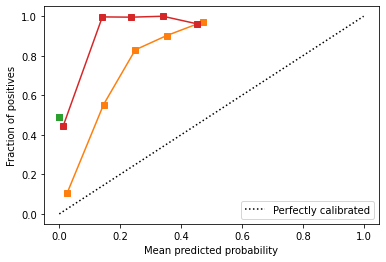

In [12]:
fig, ax = plt.subplots()
for name, model in wn_trans.items():
    plot_cal(model, ds.wn18, ax, name=name[6:-4])

## Accuracy for complEx on FB13k (1000 epoches) of difference losses

In [20]:
def plot_accs(models, data, ax=None, names=''):
    accs = {}
    for model, name in zip(models, names):
        scores = model.predict(data.X_test)
        probs = expit(scores)
        preds = probs > 0.5
        accs[name] = accuracy_score(data.y_test, preds)
    print(accs)
    pd.Series(accs).round(3).plot(kind='bar')

{'m_nll': 0.5532614191808528, 'nll': 0.5081746165514917, 'pairwise': 0.5504803640653969, 'self_adv': 0.5002949603910332}


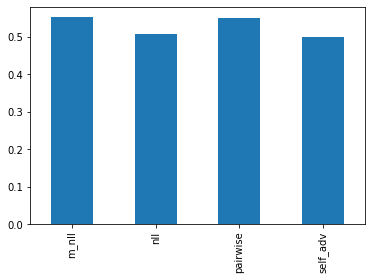

In [21]:
plot_accs(fb_comps.values(), ds.fb13, names=['m_nll', 'nll', 'pairwise', 'self_adv'])

## Histogram of scores and probas for ComplEx of differnet losses

In [39]:
def plot_score_hist(model, data, ax, name=''):
    scores = model.predict(data.X_test)
    ax.hist(scores)
    ax.set_title(name)

def plot_prob_hist(model, data, ax, name=''):
    scores = model.predict(data.X_test)
    probs = expit(scores)
    print('number of probs > 0.5', len(probs[probs>0.5]))
    ax.hist(probs)
    ax.set_xlim(0, 1)
    ax.set_title(name)

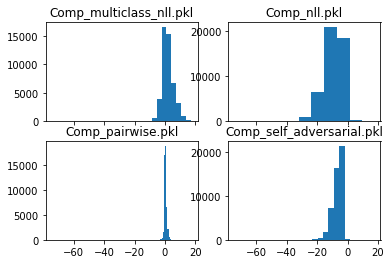

In [38]:
fig, axes = plt.subplots(2, 2, sharex=True)
for i, (name, model) in enumerate(fb_comps.items()):
    plot_score_hist(model, ds.fb13, axes[i//2][i%2], name)

number of probs > 0.5 31981
number of probs > 0.5 479
number of probs > 0.5 31989
number of probs > 0.5 37


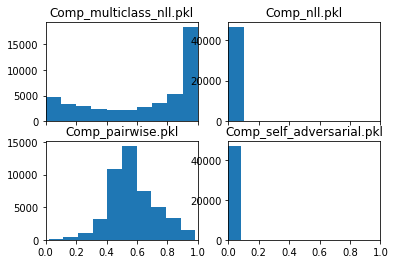

In [40]:
fig, axes = plt.subplots(2, 2, sharex=True)
for i, (name, model) in enumerate(fb_comps.items()):
    plot_prob_hist(model, ds.fb13, axes[i//2][i%2], name)

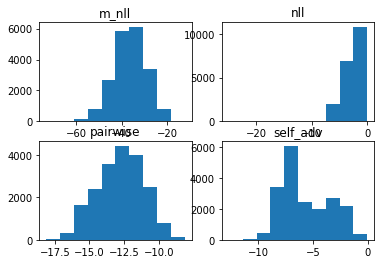

In [59]:
fig, axes = plt.subplots(2, 2)
plot_score_hist(wn_trans[0], ds.wn18, axes[0][0], 'm_nll')
plot_score_hist(wn_trans[1], ds.wn18, axes[0][1], 'nll')
plot_score_hist(wn_trans[2], ds.wn18, axes[1][0], 'pairwise')
plot_score_hist(wn_trans[3], ds.wn18, axes[1][1], 'self_adv')

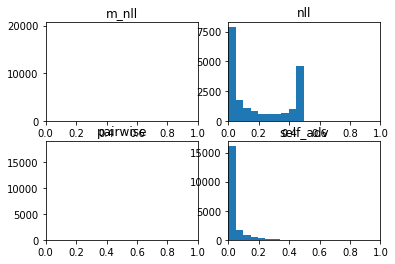

In [62]:
fig, axes = plt.subplots(2, 2, sharex=True)
for i, (name, model) in enumerate(wn_trans.items()):
    plot_prob_hist(model, ds.wn18, axes[i//2][i%2], name)

[1.1102993e-11 6.2716198e-19 3.2038752e-13 ... 1.4398927e-19 1.9294772e-12
 3.3135889e-16]


(array([1.9705e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.0497993e-32, 3.6942828e-07, 7.3885656e-07, 1.1082849e-06,
        1.4777131e-06, 1.8471414e-06, 2.2165698e-06, 2.5859981e-06,
        2.9554262e-06, 3.3248546e-06, 3.6942829e-06], dtype=float32),
 <BarContainer object of 10 artists>)

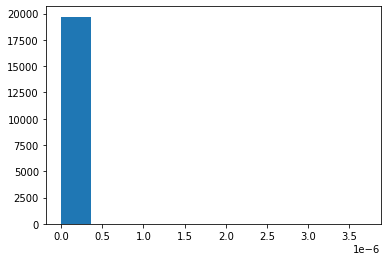

In [72]:
# probs of m_nll and pairwise are too small is illustrate within the x-axis [0, 1]
p = expit(wn_trans[0].predict(ds.wn18.X_test))
print(p)
plt.hist(p)

[3.52228162e-05 2.24648898e-06 1.39712965e-05 ... 2.46173568e-06
 1.27716303e-05 4.87206898e-06]


(array([1.8234e+04, 9.8700e+02, 2.9500e+02, 1.0700e+02, 5.4000e+01,
        1.5000e+01, 7.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.3573886e-08, 2.9075369e-05, 5.8137164e-05, 8.7198961e-05,
        1.1626075e-04, 1.4532254e-04, 1.7438435e-04, 2.0344614e-04,
        2.3250793e-04, 2.6156972e-04, 2.9063152e-04], dtype=float32),
 <BarContainer object of 10 artists>)

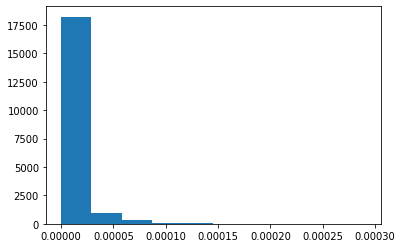

In [73]:
p = expit(wn_trans[2].predict(ds.wn18.X_test))
print(p)
plt.hist(p)

In [26]:
exp = Experiment([],[],[],[])
exp.load_trained_kges('../saved_models/trained_kges/')

Loaded trained KG embedding models.


number of probs > 0.5 14449
number of probs > 0.5 27656
number of probs > 0.5 31542
number of probs > 0.5 0


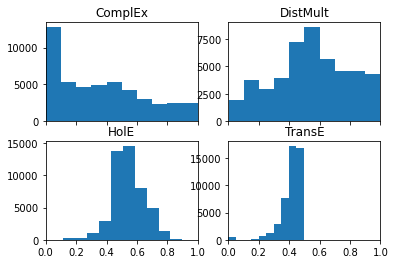

In [41]:
from probcalkge import get_cls_name
fbs = exp.trained_kges['FB13k']
fig, axes = plt.subplots(2, 2, sharex=True)
for i, m in enumerate(fbs.values()):
    plot_prob_hist(m, ds.fb13, axes[i // 2][i % 2], get_cls_name(m))

number of probs > 0.5 10183
number of probs > 0.5 11530
number of probs > 0.5 11853
number of probs > 0.5 0


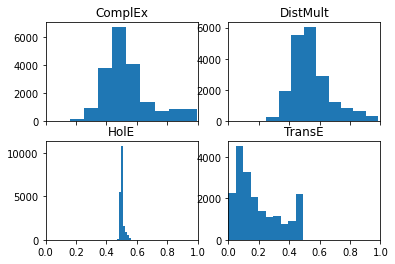

In [42]:
wns = exp.trained_kges['WN11']
fig, axes = plt.subplots(2, 2, sharex=True)
for i, m in enumerate(wns.values()):
    plot_prob_hist(m, ds.wn18, axes[i // 2][i % 2], get_cls_name(m))

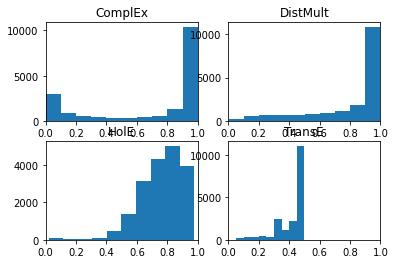

In [29]:
ygs = exp.trained_kges['YAGO39']
fig, axes = plt.subplots(2, 2)
for i, m in enumerate(ygs.values()):
    plot_prob_hist(m, ds.yago39, axes[i // 2][i % 2], get_cls_name(m))

## 200 vs 300 vs 200reg for DistMult

In [30]:
path = r'F:\TREAT\kgcal\saved_models\distmult'
dists = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

number of probs > 0.5 7848
number of probs > 0.5 2632
number of probs > 0.5 12256


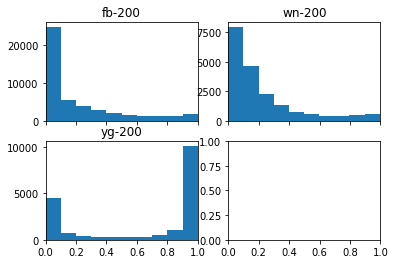

In [43]:
fig, axes = plt.subplots(2, 2, sharex=True)
plot_prob_hist(dists[1], ds.fb13, axes[0][0], 'fb-200')
plot_prob_hist(dists[4], ds.wn18, axes[0][1], 'wn-200')
plot_prob_hist(dists[7], ds.yago39, axes[1][0], 'yg-200')

# fig, axes = plt.subplots(2, 2, sharex=True)
# plot_score_hist(dists[1], ds.fb13, axes[0][0], 'fb-200')
# plot_score_hist(dists[4], ds.wn18, axes[0][1], 'wn-200')
# plot_score_hist(dists[7], ds.yago39, axes[1][0], 'yg-200')



number of probs > 0.5 7848
number of probs > 0.5 2632
number of probs > 0.5 12256


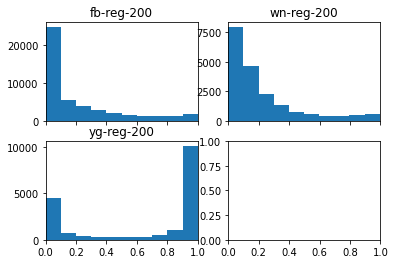

In [44]:
fig, axes = plt.subplots(2, 2, sharex=True)
plot_prob_hist(dists[0], ds.fb13, axes[0][0], 'fb-reg-200')
plot_prob_hist(dists[3], ds.wn18, axes[0][1], 'wn-reg-200')
plot_prob_hist(dists[6], ds.yago39, axes[1][0], 'yg-reg-200')

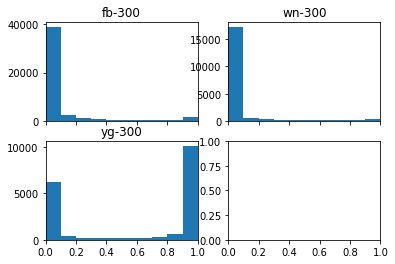

In [36]:
fig, axes = plt.subplots(2, 2, sharex=True)
plot_prob_hist(dists[2], ds.fb13, axes[0][0], 'fb-300')
plot_prob_hist(dists[5], ds.wn18, axes[0][1], 'wn-300')
plot_prob_hist(dists[8], ds.yago39, axes[1][0], 'yg-300')


In [91]:
path = r'C:\Users\s1904162\Downloads\kgcal\saved_models\comps\am_100'
am100 = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

In [92]:
path = r'C:\Users\s1904162\Downloads\kgcal\saved_models\comps\nll_100'
nll100 = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

In [93]:
path = r'C:\Users\s1904162\Downloads\kgcal\saved_models\comps\nll_200'
nll200 = [ restore_model(os.path.join(path, p)) for p in os.listdir(path) if os.path.isfile(os.path.join(path, p))]

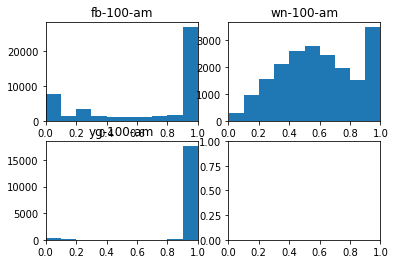

In [95]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(am100[0], ds.fb13, axes[0][0], 'fb-100-am')
plot_prob_hist(am100[1], ds.wn18, axes[0][1], 'wn-100-am')
plot_prob_hist(am100[2], ds.yago39, axes[1][0], 'yg-100-am')


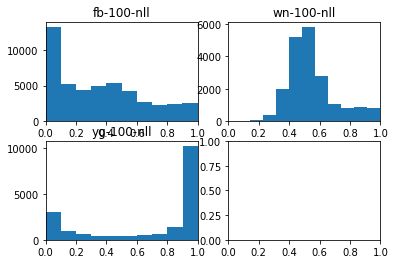

In [96]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(nll100[0], ds.fb13, axes[0][0], 'fb-100-nll')
plot_prob_hist(nll100[1], ds.wn18, axes[0][1], 'wn-100-nll')
plot_prob_hist(nll100[2], ds.yago39, axes[1][0], 'yg-100-nll')


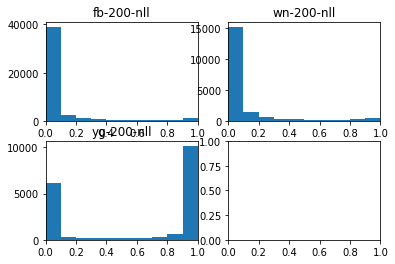

In [97]:
fig, axes = plt.subplots(2, 2)
plot_prob_hist(nll200[0], ds.fb13, axes[0][0], 'fb-200-nll')
plot_prob_hist(nll200[1], ds.wn18, axes[0][1], 'wn-200-nll')
plot_prob_hist(nll200[2], ds.yago39, axes[1][0], 'yg-200-nll')
